# ArchPy2Modflow: Transport with Modflow 6

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import geone
import geone.covModel as gcm
import geone.imgplot3d as imgplt3
import pyvista as pv
import sys
import os

# auto reload modules
%load_ext autoreload
%autoreload 2


sys.path.append("../../")
#my modules
from ArchPy.base import *
from ArchPy.tpgs import *

In [2]:
#grid
sx = 1.5
sy = 1.5
sz = .15
x0 = 0
y0 = 0
z0 = -15
nx = 100
ny = 50
nz = 50
x1 = x0 + nx*sx
y1 = y0 + ny*sy
z1 = z0 + nz*sz

dimensions = (nx, ny, nz)
spacing = (sx, sy, sz)
origin = (x0, y0, z0)  

In [16]:
## create pile

P1 = Pile(name = "P1",seed=1)

#units covmodel
covmodelD = gcm.CovModel2D(elem=[('cubic', {'w':0.6, 'r':[30,30]})])
covmodelD1 = gcm.CovModel2D(elem=[('cubic', {'w':0.2, 'r':[30,30]})])
covmodelC = gcm.CovModel2D(elem=[('cubic', {'w':0.2, 'r':[40,40]})])
covmodelB = gcm.CovModel2D(elem=[('cubic', {'w':0.6, 'r':[30,30]})])
covmodel_er = gcm.CovModel2D(elem=[('spherical', {'w':1, 'r':[50,50]})])



#create Lithologies 
dic_s_D = {"int_method" : "grf_ineq","covmodel" : covmodelD}
dic_f_D = {"f_method":"homogenous"}
D = Unit(name="D",order=1,ID = 1,color="gold",contact="onlap",surface=Surface(contact="onlap",dic_surf=dic_s_D)
         ,dic_facies=dic_f_D)

dic_s_C = {"int_method" : "grf_ineq","covmodel" : covmodelC, "mean":-8.5}
dic_f_C = {"f_method":"homogenous"}
C = Unit(name="C", order=2, ID = 2, color="blue", contact="onlap", dic_facies=dic_f_C, surface=Surface(dic_surf=dic_s_C, contact="onlap"))

dic_s_B = {"int_method" : "grf_ineq","covmodel" : covmodelB, "mean":-9.5}
dic_f_B = {"f_method":"homogenous"}
B = Unit(name="B",order=3,ID = 3,color="purple",contact="onlap",dic_facies=dic_f_B,surface=Surface(contact="onlap",dic_surf=dic_s_B))

dic_s_A = {"int_method":"grf_ineq","covmodel": covmodelB, "mean":-13}
dic_f_A = {"f_method":"homogenous"}
A = Unit(name="A",order=4, ID = 4,color="red",contact="onlap",dic_facies=dic_f_A,surface=Surface(dic_surf = dic_s_A,contact="onlap"))

#Master pile
P1.add_unit([D,C,B,A])

Unit D: Surface added for interpolation
Unit C: Surface added for interpolation
Unit B: Surface added for interpolation
Unit A: Surface added for interpolation
Stratigraphic unit D added
Stratigraphic unit C added
Stratigraphic unit B added
Stratigraphic unit A added


In [17]:
# covmodels for the property model
covmodelK = gcm.CovModel3D(elem=[("exponential",{"w":0.3,"r":[30,30,10]})],alpha=-20,name="K_vario")
covmodelK2 = gcm.CovModel3D(elem=[("spherical",{"w":0.1,"r":[20,20, 5]})],alpha=0,name="K_vario_2")

facies_1 = Facies(ID = 1,name="Sand",color="yellow")
facies_2 = Facies(ID = 2,name="Gravel",color="lightgreen")
facies_4 = Facies(ID = 4,name="Clay",color="blue")
facies_7 = Facies(ID = 7,name="basement",color="red")

A.add_facies([facies_7])
B.add_facies([facies_2])
D.add_facies([facies_1])
C.add_facies([facies_4])

# property model
cm_prop1 = gcm.CovModel3D(elem = [("spherical", {"w":0.1, "r":[10,10,10]}),
                                  ("cubic", {"w":0.1, "r":[15,15,15]})])
cm_prop2 = gcm.CovModel3D(elem = [("cubic", {"w":0.2, "r":[25, 25, 5]})])

list_facies = [facies_1, facies_2, facies_4, facies_7]
means = [-4, -2, -8, -10]
prop_model = ArchPy.base.Prop("K",
                              facies = list_facies,
                              covmodels = None,
                                means = means,
                                int_method = "homogenous",
                                vmin = -10,
                                vmax = -1
                                )

Facies basement added to unit A
Facies Gravel added to unit B
Facies Sand added to unit D
Facies Clay added to unit C


In [18]:
top = np.ones([ny,nx])*z1
bot = np.ones([ny,nx])*z0

In [19]:
T1 = Arch_table(name = "P1",seed=3)
T1.set_Pile_master(P1)
T1.add_grid(dimensions, spacing, origin, top=top,bot=bot)
T1.add_prop(prop_model)


Pile sets as Pile master
## Adding Grid ##
## Grid added and is now simulation grid ##
Property K added


In [20]:
T1.compute_surf(1)
T1.compute_facies(1)
T1.compute_prop(1)

Boreholes not processed, fully unconditional simulations will be tempted
########## PILE P1 ##########
Pile P1: ordering units
Stratigraphic units have been sorted according to order

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.0329132080078125 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.11306190490722656 s

#### COMPUTING SURFACE OF UNIT C
C: time elapsed for computing surface 0.11674237251281738 s

#### COMPUTING SURFACE OF UNIT D
D: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.04947471618652344 s
##########################


### 0.3326539993286133: Total time elapsed for computing surfaces ###

### Unit D: facies simulation with homogenous method ####
### Unit D - realization 0 ###
Time elapsed 0.0 s

### Unit C: facies simulation with homogenous method ####
### Unit C - realization 0 ###
Time elapsed 0.0 s

### Unit B: facies simulation with homogenous method ####
### Unit B - realization 0

In [27]:
pv.set_jupyter_backend("static")

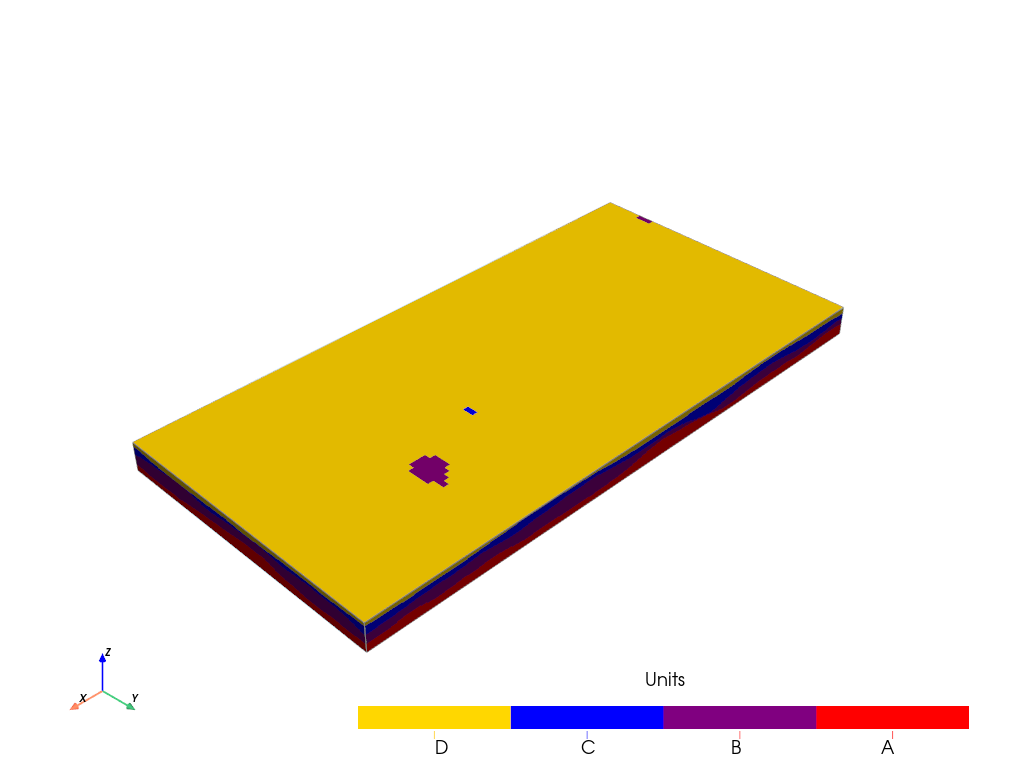

In [52]:
T1.plot_units()

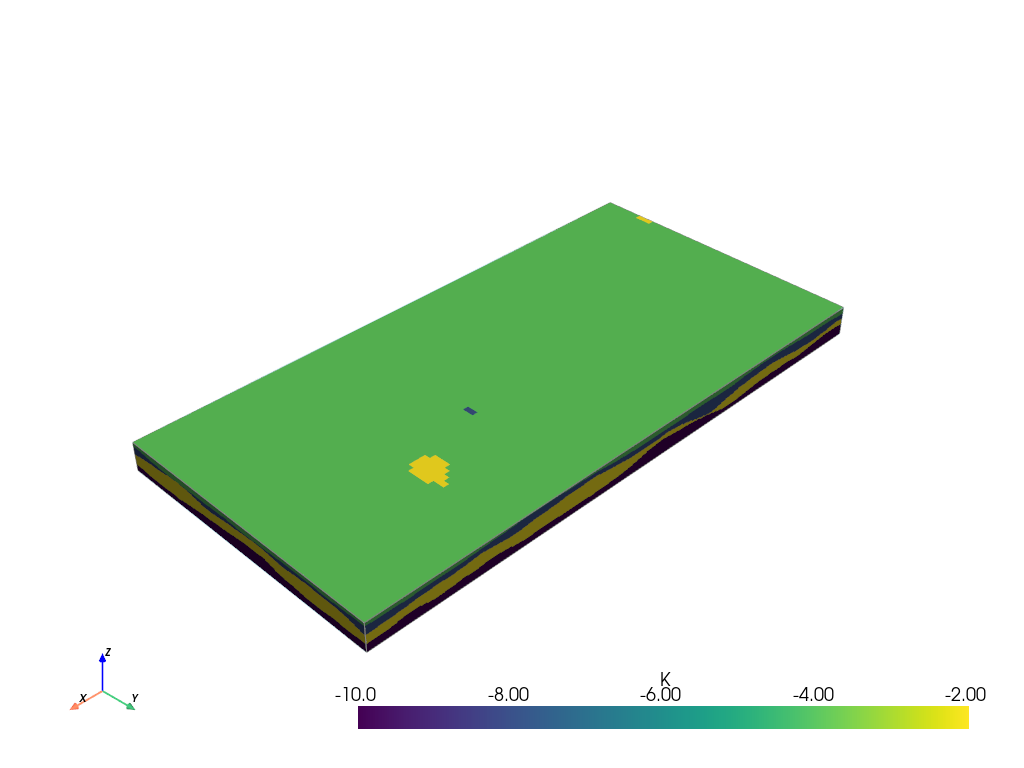

In [53]:
T1.plot_prop("K")

In [54]:
import ArchPy.ap_mf
from ArchPy.ap_mf import archpy2modflow, array2cellids

In [55]:
archpy_flow = archpy2modflow(T1, exe_name="../../../../exe/mf6.exe")  # create the modflow model
archpy_flow.create_sim(grid_mode="layers", iu=0, unit_limit="A")  # create the simulation object and choose a certain discretization
archpy_flow.set_k("K", iu=0, ifa=0, ip=0, log=True)  # set the hydraulic conductivity

Simulation created
To retrieve the simulation, use the get_sim() method


In [56]:
sim = archpy_flow.get_sim()
gwf = archpy_flow.get_gwf()

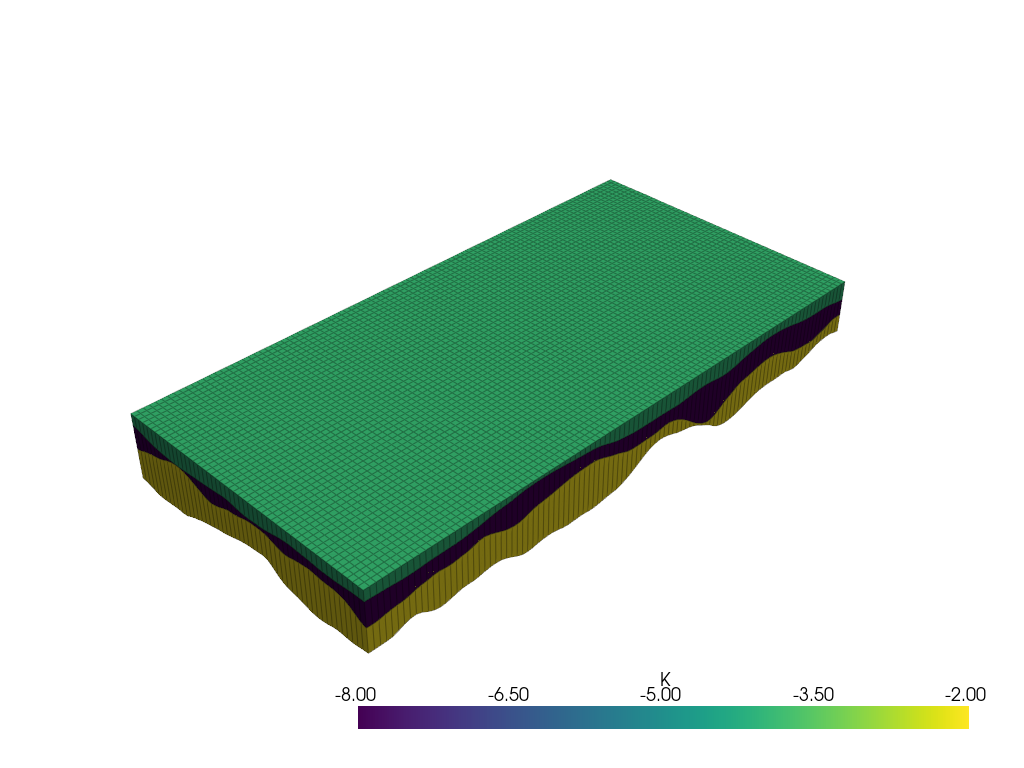

In [66]:
from flopy.export.vtk import Vtk

vert_exag = 3
vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=True)
vtk.add_model(gwf)

vtk.add_array(np.log10(gwf.npf.k.array), name="K")
vtk.add_array(gwf.dis.idomain.array, name="IDOMAIN")
gwf_mesh = vtk.to_pyvista()

ghosts = np.argwhere(gwf_mesh["K"] > 1)
gwf_mesh.remove_cells(ghosts, inplace=True)

pl = pv.Plotter(notebook=True)
pl.add_mesh(gwf_mesh, opacity=1, show_edges=True, scalars="K", cmap="viridis", clim=[-8, -2], edge_opacity=0.3)
pl.show()

In [37]:
import flopy as fp

In [38]:
# add BC at left and right on all layers
h1 = 1
h2 = 0
chd_data = []

a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, 0] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h1))

a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, -1] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h2))

chd = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_data, save_flows=True)

In [39]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model test...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 290 based on size of stress_period_data
FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled Jun 21 2024 02:57:23 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subje

(True, [])

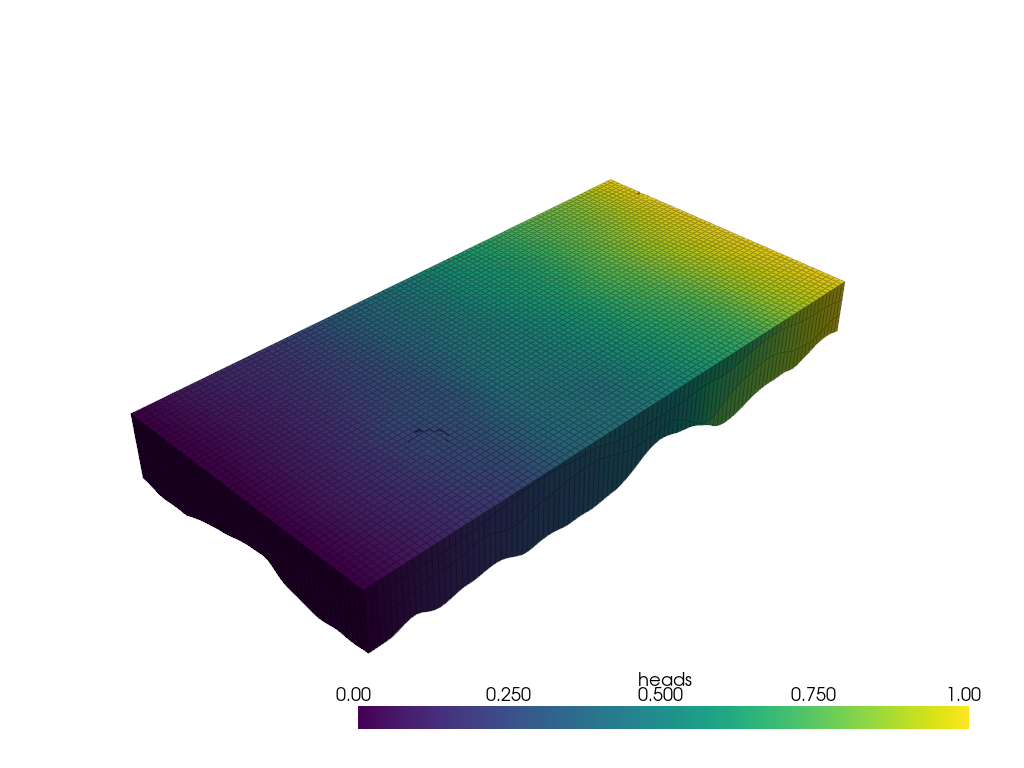

In [100]:
from flopy.export.vtk import Vtk

vert_exag = 3
vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=True)
vtk.add_model(gwf)

heads = archpy_flow.get_heads()
vtk.add_array(heads, name="heads")
vtk.add_array(np.log10(gwf.npf.k.array), name="K")

gwf_mesh = vtk.to_pyvista()
ghosts = np.argwhere(gwf_mesh["idomain"] <= 0)
gwf_mesh.remove_cells(ghosts, inplace=True)

pl = pv.Plotter(notebook=True)
pl.add_mesh(gwf_mesh, opacity=1, show_edges=True, scalars="heads", cmap="viridis", clim=[0, 1], edge_opacity=0.3)
pl.show()
